In [404]:
import importlib
%reload_ext autoreload
%autoreload
%matplotlib inline

import sys
sys.path.append('/disk/bifrost/yuanze/software/KcwiKit/py')
import os
import kcwi
import pdb


import kcwi_tools

importlib.reload(kcwi_tools)
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
import scienceplots
from matplotlib import gridspec
import matplotlib.patches as mpatches
import cmcrameri as SCM7

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel


from scipy import interpolate


KBSSpath="/disk/bifrost/yuanze/KBSS"

In [310]:
#cubename="Q1217"
sourcename="BX172"
psname="BX164"

#redshift=2.6347
#RA=184.91584
#DEC=49.66657


qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cubefile = datapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(cubename.lower(),sourcename)

if Type=='QSO' or Type=='AGN/QSO':
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
else:
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.CONTSub.fits".format(cubename.lower(),psname)


#

# 1. reproject PSF subtracted cube onto cylindrical system

In [243]:

for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
    else:
        print(psname,"is not type-1, skipping...")
        continue
    writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
    if not os.path.exists(writefn):
        print("reprojecting",psname,"to cylindrical system...")
        hdu=fits.open(Subfile)
        hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting BX160 to cylindrical system...
maximum of data5: nan
reprojecting BX164 to cylindrical system...
maximum of data5: nan
BX172 is not type-1, skipping...
BX195 is not type-1, skipping...
BX186 is not type-1, skipping...
BX298 is not type-1, skipping...
D8 is not type-1, skipping...
reprojecting RK5 to cylindrical system...
maximum of data5: nan
reprojecting BX101 to cylindrical system...
maximum of data5: nan
Lab5 is not type-1, skipping...
reprojecting GNB4950 to cylindrical system...
maximum of data5: nan
M15 is not type-1, skipping...
reprojecting MD10 to cylindrical system...
maximum of data5: nan
reprojecting MD17 to cylindrical system...
maximum of data5: nan
reprojecting KP77 to cylindrical system...
maximum of data5: nan
reprojecting KP76 to cylindrical system...
maximum of data5: nan
reprojecting KP78 to cylindrical system...
maximum of data5: nan
reprojecting BX415 to cylindrical system...
maximum of data5: nan
reprojecting Q2343 to cylindrical system...
maximum of

### Do the same for HL QSOs

In [423]:
qsos_bright=ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")
i=0
dryrun=True
for ind,field in enumerate(qsos_bright['Field']):
    sentry=qsos_bright[qsos_bright["Field"]==field]
    #cubename=sentry["Field"].value[0]
    #Type=sentry["Type"][0]
    if field=="1623":
        psname=sentry["Name"][i].split("-")[1]
        i+=1
        sentry=qsos_bright[(qsos_bright["Field"]==field) & (qsos_bright["Name"]==field+"-"+psname)]
        ssentry=qsos[qsos["Name"]==psname]
        csname=ssentry["Cube"][0]
        dapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),psname)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),psname)
    else:
        subdapath=KBSSpath+"/"+field+"/QSO"
        Subfile = subdapath+"/{}-qso_icubes_wcs.PSFCONTSub.fits".format(field.lower())
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/{}-qso_icubes_wcs.cyli.fits".format(field.lower())
    if not os.path.exists(writefn):
        print("reprojecting",sentry["Name"][0],"to cylindrical system...")
        print("reading:",Subfile)
        print("writing result to ",writefn)
        if dryrun:
            continue
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojecting Q0821+3107 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs.PSFCONTSub.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs.cyli.fits
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojected cube existed: no stacking performed 
reprojecting Q1623-KP77 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.PSFCONTSub.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.cyli.fits
reprojecting Q1623-KP77 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.PSFCONTSub

In [241]:
hdu=fits.open(Subfile)
hdu2=fits.open(cubefile)
hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
nhdu=kcwi_tools.cart2cyli(hdu2[0],[xpix,ypix],r_range=[0,10],clean=False,montage=True,montagepy=True)

maximum of data5: nan


In [234]:
testhdr=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")

In [417]:
print(np.nanmax(testhdr[0].data))
print(np.nanmax(nhdu[0].data))

2.7166420655036454
49.22491697470347


In [231]:

hdu3_1=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_1.fits")[0]
hdu3_2=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_2.fits")[0]
hdu3_3=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")[0]

data4=np.zeros((hdu3_1.shape[0],hdu3_1.shape[1],
                hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30))
data4[:,:,0:hdu3_1.shape[2]-10]=hdu3_1.data[:,:,5:hdu3_1.shape[2]-5]
data4[:,:,hdu3_1.shape[2]-10:
        hdu3_1.shape[2]+hdu3_2.shape[2]-20]=hdu3_2.data[:,:,5:hdu3_2.shape[2]-5]
data4[:,:,hdu3_1.shape[2]+hdu3_2.shape[2]-20:
        hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30]=hdu3_3.data[:,:,5:hdu3_3.shape[2]-5]
data4[data4==0]=np.nan

In [239]:
hdu3_3.shape[2]

130

In [233]:
dx=-hdu3_1.header['CD1_1']
dx0=-nhdu[0].header['CD1_1']
print(int(dx0/dx))
print(nhdu[0].header['CRVAL2'])

1
0


# 2. Stack cube together 

In [ ]:
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':

In [29]:
from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools

In [318]:
sourcename="BX172"
psname="BX164"

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cyli_cube=fits.open(subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname))

In [319]:
def create_axis(header, crval, cdelt, naxis):
    return np.arange(header[crval], header[crval] + cdelt * header[naxis], cdelt)


PA_axis=np.arange(cyli_cube[0].header['CRVAL1A'],cyli_cube[0].header['CRVAL1A']+cyli_cube[0].header['CD1_1A']*(cyli_cube[0].header['NAXIS1']),cyli_cube[0].header['CD1_1A'])
r_axis=np.arange(cyli_cube[0].header['CRVAL2A'],cyli_cube[0].header['CRVAL2A']+cyli_cube[0].header['CD2_2A']*(cyli_cube[0].header['NAXIS2']),cyli_cube[0].header['CD2_2A'])
spec_axis=np.arange(cyli_cube[0].header['CRVAL3A'],cyli_cube[0].header['CRVAL3A']+cyli_cube[0].header['CD3_3A']*(cyli_cube[0].header['NAXIS3']),cyli_cube[0].header['CD3_3A'])

In [352]:
coord=["01 03 11.27 +13 16 18.2",\
      "01 08 06.4  +16 35 50.0",\
       "01 45 16.6  -09 45 17.0",\
       "02 09 50.71 -00 05 06.5",\
       "04 52 14.3  -16 40 16.2",\
       "08 21 07.62 +31 07 51.17",\
       "10 11 55.60 +29 41 41.7",\
       "12 19 30.85 +49 40 51.2",\
       "14 44 53.67 +29 19 05.6",\
       "15 51 52.5  +19 11 04.3",\
       "16 04 55.38 +38 12 01.8",\
       "16 25 48.83 +26 46 58.8",\
       "16 25 48.1  +26 44 32.9",\
       "16 25 57.4  +26 44 48.5",\
       "17 01 00.6  +64 12 09.4",\
       "22 08 52.1  -19 43 59.7",\
       "23 46 28.30 +12 48 57.8"
      ]
for pos in coord:
    s=SkyCoord(pos,unit=(u.hourangle, u.deg))
    print(s)

<SkyCoord (ICRS): (ra, dec) in deg
    (15.79695833, 13.27172222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (17.02666667, 16.59722222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (26.31916667, -9.75472222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (32.46129167, -0.08513889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.05958333, -16.67116667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (125.28175, 31.13088056)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.98166667, 29.69491667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.87854167, 49.68088889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (221.223625, 29.31822222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (237.96875, 19.18452778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (241.23075, 38.2005)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45345833, 26.783)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45041667, 26.74247222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.48916667, 26.74680556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (255.2525, 64.20261111)>
<SkyCoor

In [60]:
da=cyli_cube[0].data

In [99]:
wdir=f"{KBSSpath}/stack_analysis"
flist=[]
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
#        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
        cyli_cube_name=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
        flist.append(cyli_cube_name)
#np.savetxt(wdir+"/source.list",np.array(flist).T,fmt='%s')

In [65]:
Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
Sub_cube = SpectralCube.read(Subfile)

In [339]:
QSOtab=qsos[((qsos['Type']=="QSO")|(qsos['Type']=="AGN/QSO"))& (qsos['R']>21)&(qsos['ext']=="True")]#&

In [340]:
result=stack_cp2d(QSOtab)

interpolating with grid:  (2599,) (50,) on (2599, 50)
interpolating with grid:  (2597,) (50,) on (2597, 50)


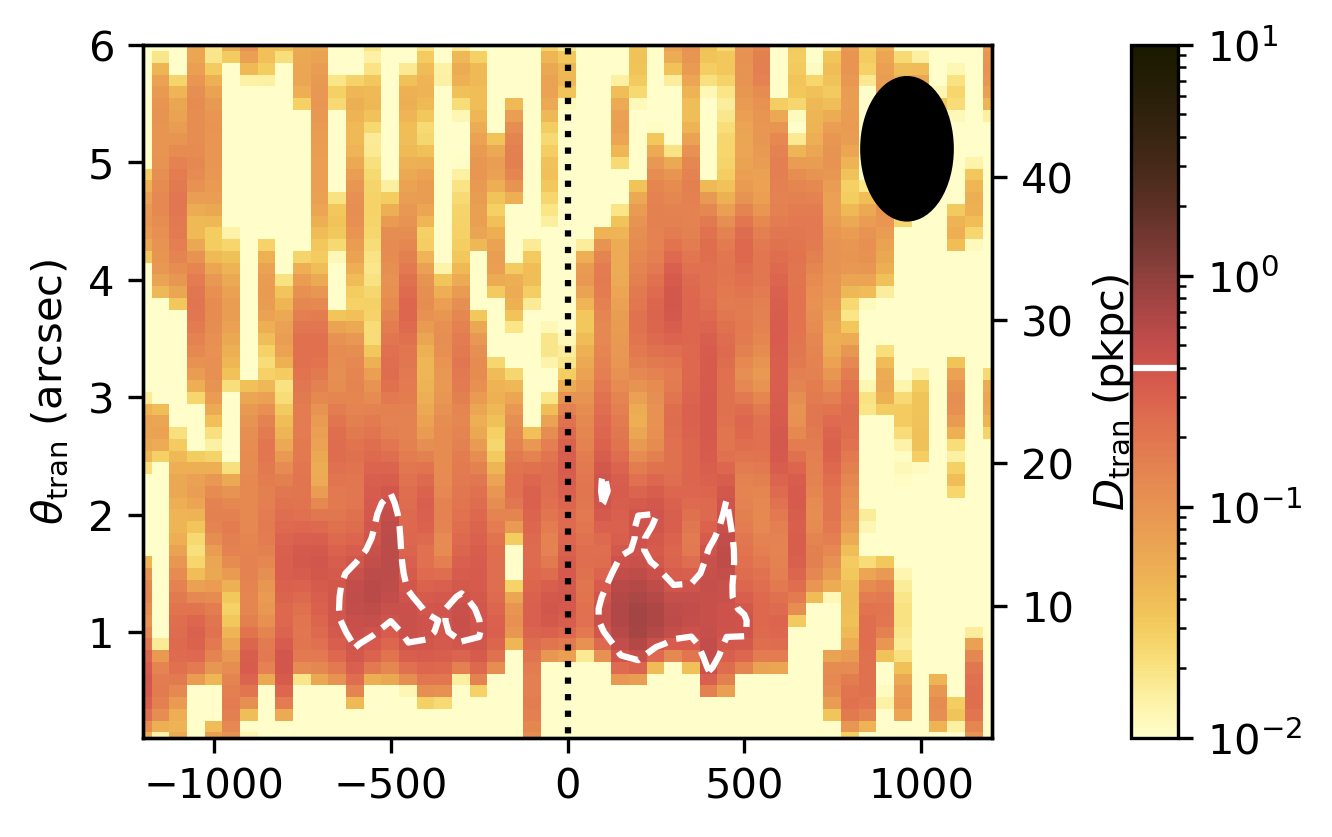

In [338]:
import common_tools
importlib.reload(common_tools)

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

common_tools.plot_cp2d(result,fig,ax,log=True)
fig.savefig("/disk/bifrost/yuanze/KBSS/stack_analysis/fig/stack_ps_faintQSOs.pdf")

In [325]:
result.shape

(250, 53)

In [321]:
def stack_cp2d(tab, norm=None, med=False, return_cube=False, nsig=None, nboot=None, igmc=False, 
               get_vlyas=False, get_rprofile=False, cont=False, full=False, noism=False): 

    xnew = np.arange(-1300, 1350, 50)
    ynew = np.arange(0, 25., 0.1)
    xcorner = np.append(xnew, xnew[-1]+50) - 25
    ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
    xmesh, ymesh = np.meshgrid(xcorner, ycorner)
    xcmesh, ycmesh = np.meshgrid(xnew, ynew)
    
    xcont_new = np.arange(-20000, 20000, 100)
    ycont_new = np.arange(0, 10, 0.1)
    xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
    ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
    xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
    xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)
    
    wcont_full = np.arange(1000, 1700, 0.5)
    xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
    ycont_full = np.arange(0, 10, 0.1)
    dxcont = xcont_full[1] - xcont_full[0]
    xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
    ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
    xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
    xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)
    
    if med:
        stackfunc = np.nanmedian
    else:
        stackfunc = np.nanmean
        
    if cont:
        xstack, ystack = xcont_new, ycont_new
        get_vlyas = False
        if full:
            xstack, ystack = xcont_full, ycont_full
            get_vlyas = False
    else:
        xstack, ystack = xnew, ynew
    
    stackcube = np.zeros((len(tab), len(ystack), len(xstack)))
    
    for i, element in enumerate(tab):
        #field = element['FILENAME'].split('-')[0]
        field=element['Field']
        objname=element['Name']
        #Type=element["Type"]
        #if Type!='QSO' and Type=='AGN/QSO':
        #    continue
        subdapath=KBSSpath+"/"+field+"/"+objname
        fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
        #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
        
        if igmc:
            fn = fn.replace('.fits', '_igmc.fits')
            
        if cont:
            fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_full_mask.fits'

        if noism:
            fn = '/Volumes/kbss-kcwi/tier3adv/' +field +'/twod/noism/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_lya_csub_noism_mask.fits'
                
        hdu = fits.open(fn)[0]
        hdr = hdu.header

        #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
        wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
        vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
        dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
        
        # interpolation
        m2d=np.nansum(hdu.data,axis=2)
        print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
        interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
        cp2d_new = interpfunc(xstack, ystack)
        
        if norm is not None:
            cp2d_new = cp2d_new / norm[i]
        
        stackcube[i, :, :] = cp2d_new
        
    
    # safety 
    stackcube[stackcube == 0] = np.nan

    
    # sigma-clipping
    if nsig is not None:
        stackcube = astropy.stats.sigma_clip(stackcube, sigma=nsig, axis=0, masked=False)
        
    # stacked cp2d
    cp2d_stack = stackfunc(stackcube, axis=0)
        
    # bootstrap
    if nboot is not None:
        bootcube = np.zeros((nboot, len(ystack), len(xstack)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        booterr = np.nanstd(bootcube, axis=0)
        
    # vlyas
    if get_vlyas:
        vlyas0 = np.zeros((len(ynew), 16)) + np.nan
        # 16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
        if nboot is not None:
            vlyas_cube = np.zeros((nboot, len(ynew), 16)) + np.nan
        
        for i in tqdm(range(len(ynew))):
            if nboot is not None:
                fitmodel0, lyamodel0, ndim0, p0, psig0 = lya_bestmod(xnew, cp2d_stack[i, :], booterr[i, :])
            else:
                fitmodel0 = fit_lya_2
                lyamodel0 = lya_model
                p0, posig = fit_lya_2(xnew, cp2d_stack[i, :], np.ones_like(xnew), absolute_sigma=False, all_p=True)

            vlyas0[i, :8] = p0
            vlyas0[i, 8:] = calc_vlya(*p0)
            
            if nboot is not None:
                for j in range(nboot):
                    p0, _ = fitmodel0(xnew, bootcube[j, i, :], np.ones_like(xnew), all_p=True)
                    vlyas_cube[j, i, :8] = p0
                    vlyas_cube[j, i, 8:] = calc_vlya(*vlyas_cube[j, i, :8])

                # get error
                vlyas_cube[vlyas_cube == -9999] = np.nan
                vlyas_err = np.nanstd(vlyas_cube, axis=0)
                
    if get_rprofile:
        if cont:
            index_c = (xstack > 2000) & (xstack <= 5000)
            sb_c0 = np.sum(cp2d_stack[:, index_c], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_c_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_c_cube[j, :] = np.sum(bootcube[j, :, index_c], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_c_sig = np.std(sb_c_cube, axis=0)
        
        else:
            index_b = (xstack > -1000) & (xstack <= 0)
            index_r = (xstack > 0) & (xstack <= 1200)
            index_a = (xstack > -1000) & (xstack <= 1200)

            sb_b0 = np.sum(cp2d_stack[:, index_b], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_r0 = np.sum(cp2d_stack[:, index_r], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_a0 = np.sum(cp2d_stack[:, index_a], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_b_cube = np.zeros((nboot, len(ystack)))
                sb_r_cube = np.zeros((nboot, len(ystack)))
                sb_a_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_b_cube[j, :] = np.sum(bootcube[j, :, index_b], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_r_cube[j, :] = np.sum(bootcube[j, :, index_r], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_a_cube[j, :] = np.sum(bootcube[j, :, index_a], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_b_sig = np.std(sb_b_cube, axis=0)
                sb_r_sig = np.std(sb_r_cube, axis=0)
                sb_a_sig = np.std(sb_a_cube, axis=0)
        
        
    
    if (return_cube==False) and (nboot is None):
        result = cp2d_stack
    else:
        result = [cp2d_stack]
        
        if return_cube:
            result.append(stackcube)
        if nboot is not None:
            result.append(booterr)
            
        if get_vlyas:
            result.append(vlyas0)
            if nboot is not None:
                result.append(vlyas_err)
                
        if get_rprofile:
            if cont:
                result.append((sb_c0))
            else:
                result.append((sb_b0, sb_r0, sb_a0))
                
            if nboot is not None:
                if cont:
                    result.append((sb_c_sig))
                else:
                    result.append((sb_b_sig, sb_r_sig, sb_a_sig))
    return result

In [152]:
tab=QSOtab
xnew = np.arange(-1300, 1350, 50)
ynew = np.arange(0, 15., 0.1)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

stackfunc = np.nanmean

xstack, ystack = xnew, ynew

stackcube = np.zeros((len(tab), len(ystack), len(xstack)))

for i, element in enumerate(tab):
    #field = element['FILENAME'].split('-')[0]
    field=element['Field']
    objname=element['Name']
    #Type=element["Type"]
    #if Type!='QSO' and Type=='AGN/QSO':
    #    continue
    subdapath=KBSSpath+"/"+field+"/"+objname
    fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
    #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
                
    hdu = fits.open(fn)[0]
    hdr = hdu.header

    #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
    wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
    vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
    dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
    
    # interpolation
    m2d=np.nansum(hdu.data,axis=2)
    print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
    interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
    cp2d_new = interpfunc(xstack, ystack)
    
    stackcube[i, :, :] = cp2d_new


interpolating with grid:  (2602,) (86,) on (2602, 86)
interpolating with grid:  (2602,) (106,) on (2602, 106)
interpolating with grid:  (2599,) (81,) on (2599, 81)
interpolating with grid:  (2597,) (73,) on (2597, 73)
interpolating with grid:  (2598,) (73,) on (2598, 73)
interpolating with grid:  (2192,) (107,) on (2192, 107)
interpolating with grid:  (2192,) (117,) on (2192, 117)
interpolating with grid:  (2597,) (87,) on (2597, 87)
interpolating with grid:  (2594,) (78,) on (2594, 78)
interpolating with grid:  (2594,) (94,) on (2594, 94)
interpolating with grid:  (2601,) (94,) on (2601, 94)
interpolating with grid:  (2599,) (100,) on (2599, 100)


In [155]:
np.max(hdu.data)

0.0

In [156]:
fn

'/disk/bifrost/yuanze/KBSS/Q2343/Q2343/kcwi_oned/q2343-Q2343_icubes_wcs.cyli.fits'

# 3. reproject PSF subtracted cube onto cylindrical system: Hyperluminous QSOs

In [643]:
qsos = ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")


In [425]:

for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    field=sentry["Field"].value[0]
    if field != 'Q1623':
        subdapath=KBSSpath+"/"+field+"/QSO"
        Subfile = subdapath+"/{}-qso_icubes_wcs.PSFCONTSub.fits".format(field.lower())
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/{}-qso_icubes_wcs.cyli.fits".format(field.lower())
    else:
        continue
        #name=sentry["Name"].split[1]
        #subdapath=KBSSpath+"/"+field+"/"+name
        #Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),name)
        #xpix = sentry["x"].value[0]
        #ypix = sentry["y"].value[0]
        #writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
    if not os.path.exists(writefn):
        print("reprojecting",psname,"to cylindrical system...")
        hdu=fits.open(Subfile)
        hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print(f"reprojected cube existed for {psname:s}: no stacking performed ")


reprojected cube existed for Q0100+13: no stacking performed 
reprojected cube existed for HS0105+1619: no stacking performed 
reprojected cube existed for Q0142-10: no stacking performed 
reprojected cube existed for Q0207-003: no stacking performed 
reprojecting Q0821+3107 to cylindrical system...
reprojected cube existed for Q1009+29: no stacking performed 
reprojected cube existed for Q1217+490: no stacking performed 
reprojected cube existed for Q1442+2931: no stacking performed 
reprojected cube existed for Q1549+1919: no stacking performed 
reprojected cube existed for HS1603+3820: no stacking performed 
reprojected cube existed for HS1700+64: no stacking performed 
reprojected cube existed for Q2206-199: no stacking performed 
reprojected cube existed for Q2343+12: no stacking performed 


## Reprojection completed! Do the stacking.

In [451]:
xnew = np.arange(-1600, 2000, 50)
ynew = np.arange(0, 25., 0.1)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

def stack_cp2d(tab, norm=None, med=False, return_cube=False, nsig=None, nboot=None, igmc=False, 
               get_vlyas=False, get_rprofile=False, cont=False, full=False, noism=False): 
    if med:
        stackfunc = np.nanmedian
    else:
        stackfunc = np.nanmean
        
    if cont:
        xstack, ystack = xcont_new, ycont_new
        get_vlyas = False
        if full:
            xstack, ystack = xcont_full, ycont_full
            get_vlyas = False
    else:
        xstack, ystack = xnew, ynew
    
    stackcube = np.zeros((len(tab), len(ystack), len(xstack)))
    
    for i, element in enumerate(tab):
        #field = element['FILENAME'].split('-')[0]
        field=element['Field']
        if field != "Q1623":
            objname="qso"
            subdapath=KBSSpath+"/"+field+"/"+objname.upper()
            fn=subdapath+"/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
        else:
            objname=element['Name'].split("-")[1]
            subdapath=KBSSpath+"/"+field+"/"+objname.upper()
            fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
        #Type=element["Type"]
        #if Type!='QSO' and Type=='AGN/QSO':
        #    continue
        
        #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
        
        if igmc:
            fn = fn.replace('.fits', '_igmc.fits')
            
        if cont:
            fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_full_mask.fits'

        if noism:
            fn = '/Volumes/kbss-kcwi/tier3adv/' +field +'/twod/noism/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_lya_csub_noism_mask.fits'
                
        hdu = fits.open(fn)[0]
        hdr = hdu.header

        #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
        wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
        vc = (wc / (1 + element['z_sys']) - 1215.67) / 1215.67 *3e5
        dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
        
        # interpolation
        m2d=np.nansum(hdu.data,axis=2)
        print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
        interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
        cp2d_new = interpfunc(xstack, ystack)
        
        if norm is not None:
            cp2d_new = cp2d_new / norm[i]
        
        stackcube[i, :, :] = cp2d_new
        
    
    # safety 
    stackcube[stackcube == 0] = np.nan

    
    # sigma-clipping
    if nsig is not None:
        stackcube = astropy.stats.sigma_clip(stackcube, sigma=nsig, axis=0, masked=False)
        
    # stacked cp2d
    cp2d_stack = stackfunc(stackcube, axis=0)
        
    # bootstrap
    if nboot is not None:
        bootcube = np.zeros((nboot, len(ystack), len(xstack)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        booterr = np.nanstd(bootcube, axis=0)
        
    # vlyas
    if get_vlyas:
        vlyas0 = np.zeros((len(ynew), 16)) + np.nan
        # 16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
        if nboot is not None:
            vlyas_cube = np.zeros((nboot, len(ynew), 16)) + np.nan
        
        for i in tqdm(range(len(ynew))):
            if nboot is not None:
                fitmodel0, lyamodel0, ndim0, p0, psig0 = lya_bestmod(xnew, cp2d_stack[i, :], booterr[i, :])
            else:
                fitmodel0 = fit_lya_2
                lyamodel0 = lya_model
                p0, posig = fit_lya_2(xnew, cp2d_stack[i, :], np.ones_like(xnew), absolute_sigma=False, all_p=True)

            vlyas0[i, :8] = p0
            vlyas0[i, 8:] = calc_vlya(*p0)
            
            if nboot is not None:
                for j in range(nboot):
                    p0, _ = fitmodel0(xnew, bootcube[j, i, :], np.ones_like(xnew), all_p=True)
                    vlyas_cube[j, i, :8] = p0
                    vlyas_cube[j, i, 8:] = calc_vlya(*vlyas_cube[j, i, :8])

                # get error
                vlyas_cube[vlyas_cube == -9999] = np.nan
                vlyas_err = np.nanstd(vlyas_cube, axis=0)
                
    if get_rprofile:
        if cont:
            index_c = (xstack > 2000) & (xstack <= 5000)
            sb_c0 = np.sum(cp2d_stack[:, index_c], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_c_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_c_cube[j, :] = np.sum(bootcube[j, :, index_c], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_c_sig = np.std(sb_c_cube, axis=0)
        
        else:
            index_b = (xstack > -1000) & (xstack <= 0)
            index_r = (xstack > 0) & (xstack <= 1200)
            index_a = (xstack > -1000) & (xstack <= 1200)

            sb_b0 = np.sum(cp2d_stack[:, index_b], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_r0 = np.sum(cp2d_stack[:, index_r], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_a0 = np.sum(cp2d_stack[:, index_a], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_b_cube = np.zeros((nboot, len(ystack)))
                sb_r_cube = np.zeros((nboot, len(ystack)))
                sb_a_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_b_cube[j, :] = np.sum(bootcube[j, :, index_b], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_r_cube[j, :] = np.sum(bootcube[j, :, index_r], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_a_cube[j, :] = np.sum(bootcube[j, :, index_a], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_b_sig = np.std(sb_b_cube, axis=0)
                sb_r_sig = np.std(sb_r_cube, axis=0)
                sb_a_sig = np.std(sb_a_cube, axis=0)
        
        
    
    if (return_cube==False) and (nboot is None):
        result = cp2d_stack
    else:
        result = [cp2d_stack]
        
        if return_cube:
            result.append(stackcube)
        if nboot is not None:
            result.append(booterr)
            
        if get_vlyas:
            result.append(vlyas0)
            if nboot is not None:
                result.append(vlyas_err)
                
        if get_rprofile:
            if cont:
                result.append((sb_c0))
            else:
                result.append((sb_b0, sb_r0, sb_a0))
                
            if nboot is not None:
                if cont:
                    result.append((sb_c_sig))
                else:
                    result.append((sb_b_sig, sb_r_sig, sb_a_sig))
    return result


def plot_cp2d(cp2d, fig, ax, log=True, norm=True, snr=False, cont=False,PSFSub=False, HL=False,cosmo=Planck18):
    if HL:
        upper=0.2*np.max(cp2d)
    else:
        upper=np.max(cp2d)
    if log:
        cnorm = matplotlib.colors.LogNorm(vmin=0.005 / 100, vmax=1/10)
        levels = np.arange(0.2, upper, 0.2) / 100
        if norm:
            cnorm = matplotlib.colors.LogNorm(vmin=0.01, vmax=10)
            levels = np.arange(0.4, upper, 1.0)
    else:
        cnorm = matplotlib.colors.Normalize(vmin=0, vmax=0.5/100)
        levels = np.arange(0.2, upper, 0.2) / 100
        if norm:
            cnorm = matplotlib.colors.Normalize(vmin=0, vmax=1)
            levels = np.arange(0.4, upper, 0.4)
            
    if snr:
        cnorm = matplotlib.colors.Normalize(vmin=0, vmax=10)
        levels = np.arange(1, upper, 1)
    
    cp2d_mesh = cp2d.copy()
    cp2d_mesh[cp2d_mesh <= 0] = 1e-16
    if cont==False:
        mesh=ax.pcolormesh(xmesh, ymesh, cp2d_mesh, norm=cnorm, cmap=SCM7.cm.lajolla_r)
        mesh.set_rasterized(True)
        ct=ax.contour(xcmesh, ycmesh, cp2d,
                  levels=levels,
                  colors='white', linestyles='dashed')
    else:
        mesh=ax.pcolormesh(xcont_mesh, ycont_mesh, cp2d_mesh, norm=cnorm, cmap=SCM7.cm.lajolla_r)
        mesh.set_rasterized(True)
        ct=ax.contour(xccont_mesh, yccont_mesh, cp2d,
                  levels=levels,
                  colors='white', linestyles='dashed')
    ax.plot([0,0],[0,10], ':', lw=1.5, color='black')
    ax.set_xlim(-1200, 1200)
    if PSFSub:
        ax.set_ylim(0.1,6)
    else:
        ax.set_ylim(0.1,6)
    ax.set_ylabel(r'$\theta_\mathrm{tran}$ (arcsec)')

    ax2 = ax.twinx()
    ax2.set_ylabel(r'$D_\mathrm{tran}$ (pkpc)')  # we already handled the x-label with ax1
    ax2.set_ylim(np.array(ax.get_ylim())/60*cosmo.kpc_proper_per_arcmin(2.3).value)


    resolution=mpatches.Ellipse((0.9,0.85),3e5/1422./2000,1.0/4.9,color='black',fill=True,zorder=10,transform=ax.transAxes)
    ax.add_artist(resolution)

    cbar=fig.colorbar(mesh,ax=ax2,pad=0.12,aspect=15)
    cbar.add_lines(ct)
    
    return

In [671]:
QSOtab=qsos[(qsos['contam']=="False")&(qsos['r']<19.)]

In [672]:
QSOtab

Name,Field,RA,Dec,x,y,EBV,z_simbad,z_sys,zerr,contam,u,g,r,i,z,MB,Comments
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit
str11,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,str40
Q0100+13,Q0100,15.797,13.272,50.46,50.41,0.031,2.686,2.721,0.001,False,17.4,16.7,16.5,16.5,--,-26.4472,--
HS0105+1619,Q0105,17.027,16.597,52.31,53.45,0.058,2.64,2.652,0.001,False,18.1,17.19,17.0,16.87,16.67,--,--
Q0207-003,Q0207,32.461,-0.085,49.95,50.93,0.024,2.85,2.872,0.001,False,18.08,17.02,16.92,16.84,16.76,--,--
Q0821+3107,Q0821,125.282,31.131,54.68,52.86,0.039,2.624,2.616,0.001,False,18.08,17.26,17.04,16.87,16.66,--,--
Q1009+29,Q1009,152.982,29.695,48.79,48.47,0.023,2.62,2.652,0.001,False,16.73,16.16,16.09,16.02,15.89,-26.7954,--
Q1217+490,Q1217,184.879,49.681,47.9,43.83,0.015,2.698,2.704,0.001,False,17.77,17.09,16.92,16.79,16.7,-25.9884,--
Q1549+1919,Q1549,237.969,19.185,49.0,68.55,0.04,2.83,2.843,0.001,False,17.06,16.06,15.89,15.77,15.7,-27.0722,--
HS1603+3820,Q1603,241.231,38.201,40.49,45.81,0.01,2.51,2.551,0.001,False,16.74,16.11,15.93,15.85,15.67,-27.0,--


In [673]:
result=stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,nboot=500)

interpolating with grid:  (2597,) (50,) on (2597, 50)
interpolating with grid:  (2596,) (50,) on (2596, 50)
interpolating with grid:  (2596,) (50,) on (2596, 50)
interpolating with grid:  (2596,) (50,) on (2596, 50)
interpolating with grid:  (2595,) (50,) on (2595, 50)
interpolating with grid:  (2594,) (50,) on (2594, 50)
interpolating with grid:  (2595,) (50,) on (2595, 50)
interpolating with grid:  (2594,) (50,) on (2594, 50)
interpolating with grid:  (2597,) (50,) on (2597, 50)
interpolating with grid:  (2594,) (50,) on (2594, 50)
interpolating with grid:  (2595,) (50,) on (2595, 50)
interpolating with grid:  (2599,) (50,) on (2599, 50)
interpolating with grid:  (2599,) (50,) on (2599, 50)


/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: Mean of empty slice


In [674]:
result[2].shape

(250, 72)

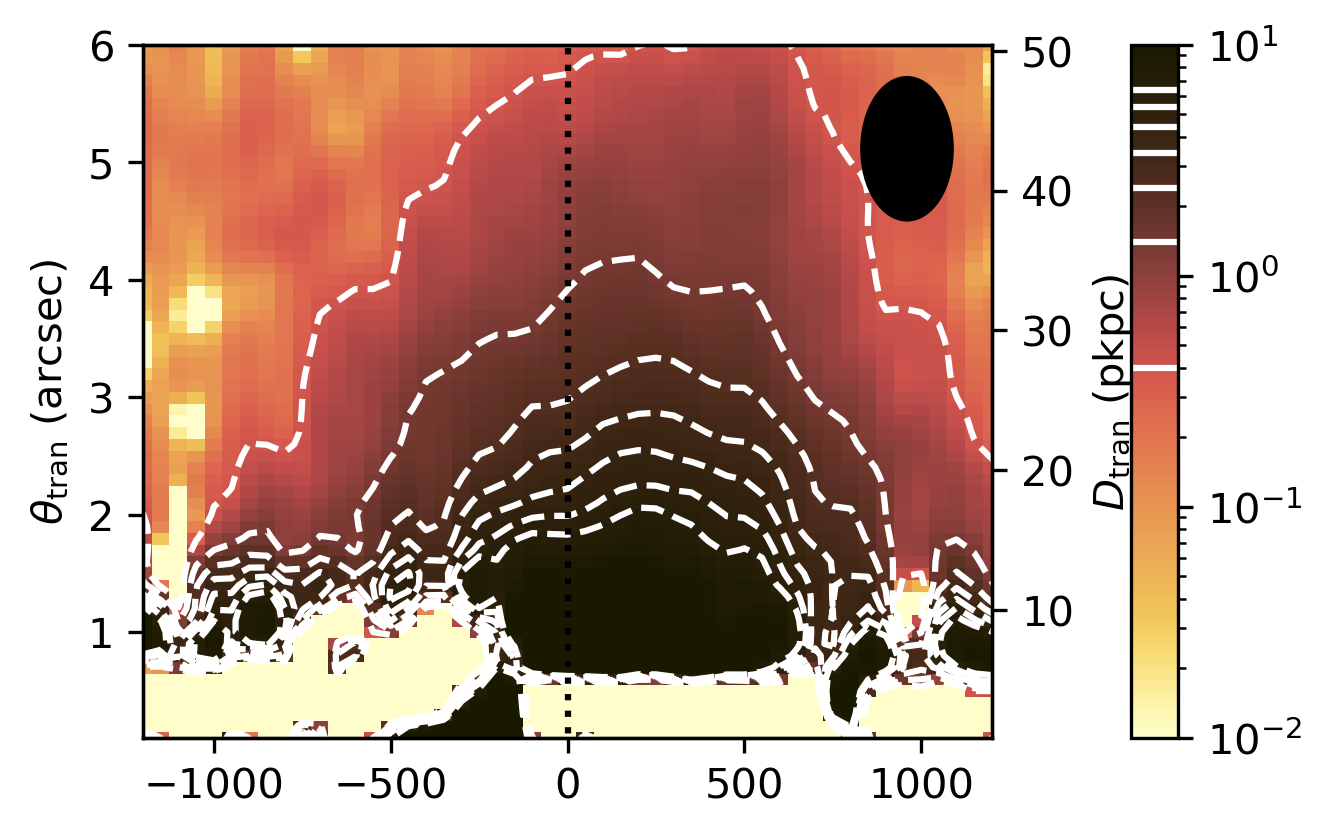

In [675]:
#import common_tools
#importlib.reload(common_tools)
from astropy.cosmology import Planck18
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

plot_cp2d(result[0],fig,ax,log=True,PSFSub=True,HL=True,cosmo=Planck18)
#fig.savefig("/disk/bifrost/yuanze/KBSS/stack_analysis/fig/stack_ps_HLQSOs.pdf")

Text(0, 0.5, 'SB $\\rm (10^{-16}~erg~s^{-1}~cm^{-2})$')

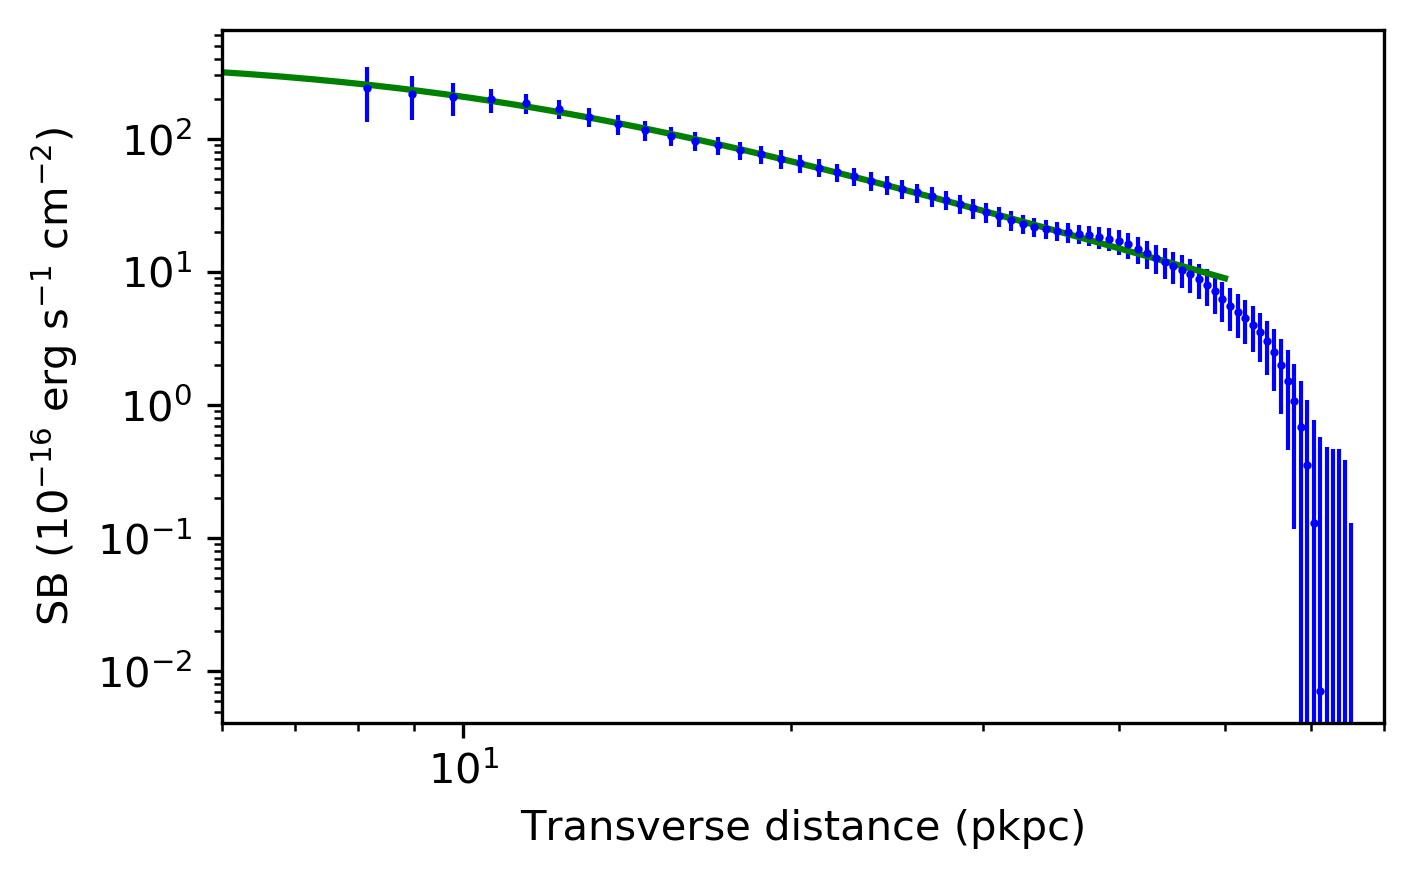

In [695]:
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=10
cut2=40
side=2
ax.errorbar(kpc_per_arcsec*ynew[cut1:],result[3][side][cut1:],yerr=result[4][side][cut1:]
            ,fmt="o",
        #label="(Obs-Mod)/Obs",
        color="b",
            mfc="none",
            ms=1.,
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#model = models.PowerLaw1D(amplitude=100,x_0=10.,alpha=3)+models.PowerLaw1D(amplitude=100,x_0=26,alpha=2)*models.Exponential1D(amplitude=10,tau=-3)
#+models.Moffat1D(amplitude=10,x_0=50)
model = models.Moffat1D(amplitude=343.27101226, x_0=0., gamma=35.12890817, alpha=5.97021926)\
#+models.PowerLaw1D(amplitude=10,x_0=40.,alpha=3)*models.Exponential1D(amplitude=10,tau=-5)#
#model.x_0_0.fixed=True
#model.amplitude_0.fixed=True
#model.amplitude_1.fixed=True
#model.gamma_0.fixed=True
#model.alpha_0.fixed=True
#model.n.fixed=True
#model.x_0.fixed=True
fitter = fitting.LevMarLSQFitter()
# Fit the model
fitted_model = fitter(model,kpc_per_arcsec*ynew[cut1:cut2],result[3][side][cut1:cut2],weights=1/result[4][side][cut1:cut2])
#print(fitted_model)

x_fit = np.linspace(3, 50, 100)
y_fit=fitted_model(x_fit)
ax.plot(x_fit,y_fit,"g")

#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([6,70])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Transverse distance (pkpc)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2})$")
#fig.savefig(KBSSpath+"/"+field+"/"+sourcename+"/kcwi_oned/SB_profile.pdf")

In [668]:
40/kpc_per_arcsec/0.3

16.351016886264265